# Lindblad simulation notebook

Useful literature:

- [1] T. Prosen, "Exact nonequilibrium steady state of a strongly driven open XXZ chain", arXiv:1106.2978, https://arxiv.org/abs/1106.2978 (2011)
- [2] R. Cleve, C. Wang, "Efficient Quantum Algorithms for Simulating Lindblad Evolution", arXiv:1612.09512, https://arxiv.org/abs/1612.09512 (2016)
- [3] H. Chen et al., "A Randomized Method for Simulating Lindblad Equations and Thermal State Preparation", arXiv:2407.06594v2, https://arxiv.org/abs/2407.06594v2 (2024)
- [4] Z. Ding et al. "Simulating Open Quantum Systems Using Hamiltonian Simulations", arXiv:2311.15533, https://arxiv.org/abs/2311.15533 (2023)
- [5] Brunner et al. "Lindblad engineering for quantum Gibbs state preparation under the eigenstate thermalization hypothesis", arXiv:2412.17706, https://arxiv.org/abs/2412.17706 (2024)
- [6] T. Prosen, I. Pizorn, "Quantum phase transition in a far from equilibrium steady state of XY spin chain", arXiv:0805.2878, https://arxiv.org/abs/0805.2878 (2008)
- [7] J. Jin et al., "Cluster mean-field approach to the steady-state phase diagram of dissipative spin systems", arXiv:1602.06553, https://arxiv.org/abs/1602.06553 (2016)

This is the Lindblad part of the iquhack25 Quantinuum challenge. The aim is to implement the dynamics of a dissipative quantum system (i.e. an open system coupled to an environment), which is described by a Lindbladian $\mathcal{L}$. In comparison to this, a quantum systems is described by a Hamiltonian $H$, as we saw in the notebook `notebooks/hamiltonian_simulation.ipynb`. 

As an example we consider the system studied in [1]. The system is a XXZ Heisenberg spin chain, coupled to an environment at the edges of the chain.

In [4]:
# configure some visualisations

from pytket.circuit.display import get_circuit_renderer

circuit_renderer = get_circuit_renderer()

circuit_renderer.set_render_options(zx_style=False)
circuit_renderer.set_render_options(crop_params=False)
circuit_renderer.save_render_options()

## Background

The Lindbladian is a "supoeroperator", acting on a quantum state $\rho$ by
$$
\mathcal{L}[\rho]
= -i [H, \rho] + \mathcal{D} [\rho]
= -i [H, \rho] + \sum_{i = 1}^S \mathcal{D}_i [\rho] \,,
\quad \text{with} \quad
\mathcal{D}_i [\rho] = L_i \rho L_i^\dagger - \frac{1}{2} \lbrace L_i^\dagger L_i, \rho \rbrace \,,
$$
where $S$ is the number of jump operators.
The first term is the coherent part, describing coherent (unitary) evolution under the system Hamiltonian, the second part is the dissipative part describing the interaction of the system with the environment.
The Lindbladian $\mathcal{L}$ generates a Lindbladian (or dissipative) time evolution given by
$$
\rho(t) = e^{t \mathcal{L}} [\rho(0)] \,,
$$
where $\rho(0)$ is the initial state.

The notation $\rho$ instead of $\ket{\psi}$ indicates that we are working with mixed quantum states now, which is slightly more general. You don't need to know what mixed states are for this challenge. For now just assume we use a different symbol than $\ket{\psi}$ for the quantum state in this notebook. Explicit circuit pictures are given below.

The time evolution under the Lindbladian $\mathcal{L}$ is implemented (similar to Trotterization) by means of a product formula, factorizing the coherent and dissipative parts.
Let $T$ be the target evolution time. We disretize the time interval $[0,T]$ into $M \in \mathbb{N}$ equidistant time steps of size $\Delta t = T / M$.
The time evolution up to time $T = M \Delta t$ is approximated by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
i.e. we factorize the coherent and dissipative parts. In each time step, we concatenate coherent evolution for $\Delta t$ with the dissipative evolution for time $\Delta t$.

A mixed state $\rho$ is a matrix representation of the quantum state, in contrast to $\ket{\psi}$ which is a vector representation of a quantum state. Therefore, $\rho$ is also called density matrix, and time evolution acts on it by acting with the time evolution operator on both sides as in the formula above. This does not change the quantum circuit that we have to implement. Explicit quantum circuit pictures are given below.

### The dissipative XXZ Heisenberg model

We consider the model proposed in [1]. The Hamiltonian of the dissipative system is given by the XXZ Heisenberg model, which we already know from the other notebook `notebooks/hamiltonian_simulation.ipynb`. It is given by
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)} \,.
$$
Here $\sigma_{\pm} = \frac{1}{2}(X \pm i Y)$ and, as before $A^{(k)} = I \otimes \cdots \otimes I \otimes A \otimes I \otimes \cdots \otimes I$, where $A \in \lbrace X, Y, Z, \sigma_+, \sigma_- \rbrace$ is inserted on the $k$-th position, i.e. it is acting on the $k$-th qubits. Identities $I$ mean that no operations are performed on those qubits.

The first two terms describe hopping of a spin between neighboring sites, the third term, quantified by $\Delta$, describes the repulsive interaction of two adjacent spins.

We can recast this Hamiltonian into
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)}
= \sum_{j = 1}^{N-1} X^{(j)} X^{(j+1)} + Y^{(j)} Y^{(j+1)} + \Delta Z^{(j)} Z^{(j+1)} \,,
$$
which is the form of the XXZ Heisenberg model which we already used in `notebooks/hamiltonian_simulation.ipynb`.


The dissipative character of the system is modelled by the jump operators. In this case we only have two of them, one on each side of the chain.
They are given by $L_1 = \sqrt{2\epsilon} \sigma^{(1)}_+$ and $L_2 = \sqrt{2\epsilon} \sigma^{(N)}_-$.
The jump operator $L_1$ models qubit excitations that are injected from the environment into the spin chain from the left. The operator $L_2$ describes how those excitations are transmitted from the right end of the chain back into the environment. One task of this challenge is to reproduce the spin profile given in Fig. 2 of [1], showing the expected spin excitation imbalance from left to right.

Below we give a detailed description of the Lindblad simulation algorithm, which is based out of two parts that are applied sequentially: (i) The coherent time evolution we already studied in `notebooks/hamiltonian_simulation.ipynb`, and (ii) the dissipative part, which is new. If you want read more on this, and how it is applied in different situations, see e.g. Fig. 1 in [4], Sec. IV and App. B in [5], or relevant parts of [2,3]. This literature is, however, not necessary for the tasks below.

### Implementation of the coherent part

Let us start with the coherent part $\mathcal{U}_{\Delta t}$ of the Lindbladian. The first term of the Lindbladian $-i[H, \rho]$ generates the unitary evolution of the system under the evolution operator $\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H}$. This part can be implemented via Trotterisation, which we studied in the notebook `notebooks/hamiltonian_simulation.ipynb`.


### Implementation of the dissipative part

The dissipative part is implemented via a so-called dilation of the jump operators, which requires an additional ancilla qubits which will be traced out later.
The dilation of the jump operator $L_i$ for our system, as proposed in [1], is given by
$$
K_i 
= \ket{1}\bra{0}_\mathrm{anc} \otimes L_i + \ket{0}\bra{1}_\mathrm{anc} \otimes L_i^\dagger 
= X_\mathrm{anc} \otimes \frac{L_i + L_i^\dagger}{2} - i Y_\mathrm{anc} \otimes \frac{L_i - L_i^\dagger}{2} \,.
$$


We wish to generate the Lindblad simulation circuit. One step for this is building the dilation operator, which is a Hermitian operator. This can be simulated with Hamiltonian simulation via Trotterization.

Let's consider our jump operators. We have $L_1 + L_1^\dagger = \sqrt{2\epsilon} X^{(1)}$ and $L_1 - L_1^\dagger = i \sqrt{2\epsilon} Y^{(1)}$. For the second jump operator we have $L_2 + L_2^\dagger = \sqrt{2\epsilon} X^{(N)}$ and $L_2 - L_2^\dagger = -i\sqrt{2\epsilon} Y^{(N)}$. Therefore, in our case the dilation is given by
$$
\begin{split}
K_1 
&= X^\mathrm{(anc)}  \frac{\sqrt{2\epsilon}}{2} X^{(1)} - i Y^\mathrm{(anc)}  i \frac{\sqrt{2\epsilon}}{2} Y^{(1)}
= \frac{\sqrt{2\epsilon}}{2} X^\mathrm{(anc)}  X^{(1)} + \frac{\sqrt{2\epsilon}}{2} Y^\mathrm{(anc)}  Y^{(1)} 
= K_1^1 + K_1^2 \\
K_2
&= X^\mathrm{(anc)}  \frac{\sqrt{2\epsilon}}{2} X^{(N)} - i Y^\mathrm{(anc)}  (-1) i \frac{\sqrt{2\epsilon}}{2} Y^{(N)}
= \frac{\sqrt{2\epsilon}}{2} X^\mathrm{(anc)}  X^{(N)} - \frac{\sqrt{2\epsilon}}{2} Y^\mathrm{(anc)}  Y^{(N)}
= K_2^1 + K_2^2 \,.
\end{split}
$$

##### Deterministic protocol:

To implement the dissipative part of the dynamics, we need to perform Hamiltonian simulation of the dilation operators $K_i$. After one step of time evolution, we have to trace out the ancilla qubit and reset it, to ensure that our circuit performs the targeted dynamical step.

This is accomplished by the following:
$$
\begin{split}
    &\mathrm{tr}_{\rm anc_1 anc_2} \big[ 
        e^{-i\sqrt{ \Delta t} K_1} e^{-i\sqrt{ \Delta t} K_{2}} 
        (\ket{0}\bra{0}_{\rm anc_1} \otimes\dots\otimes \ket{0}\bra{0}_{\rm anc_2} \otimes \rho) 
        e^{i\sqrt{ \Delta t} K_1} e^{i\sqrt{ \Delta t} K_{2}} 
    \big] 
    \\
    &= 
    e^{\Delta t \mathcal{D}}[\rho] + {\cal O}( \Delta t^2) \,.
\end{split}
$$

which can be visualized by the circuit

<img src="../circuit_pictures/deterministic_protocol.png" alt="drawing" width="500"/>



This implementation results in an error, similar to the second order Trotterization error which we studied in `notebooks/hamiltonian_simulation.ipynb`, of order $\Delta t^2$.

##### Randomized single-ancilla protocol (alternative approach):

The above protocol can be randomized. That means that in each time step, we select on of the jump operators at random, and only apply the corresponding dilated operator.
This means, that we approximate the time evolution up to time $T = M \Delta t$ by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
= \left( \prod_{i = 1}^M e^{S \Delta t \mathcal{D}_{a_i}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
where in each time step $i$ we randomly select one of the jump operators $L_{a_i}$ and apply the corresponding single-jump dissipator $\mathcal{D}_{a_i}$. Note the number of jump operators $S$ appearing in the exponent $e^{S \Delta t \mathcal{D}_{a_i}}$.

With this approach we only need a single ancilla qubit, and each time step is implemented with a shallower circuit as in the deterministic approach. This comes at the cost of inducing an additional error through randomization. This error needs to be controlled by running several "random runs" of the algorithm, and averaging the results.
Based on the dilation, the evolution under the dissipator $\mathcal{D}_i$ is approximately implemented via
$$
\mathrm{tr}_\mathrm{anc} \left[ e^{ -i \sqrt{S \Delta t}K_i} \left( \ket{0}\bra{0}_\mathrm{anc} \otimes \rho \right) e^{ i \sqrt{S \Delta t}K_i} \right]
= e^{S \Delta t \mathcal{D}_{a_i}} [\rho] + \mathcal{O}(\Delta t^2) \,,
$$
which induce an error of order $\Delta t^2$.

<img src="../circuit_pictures/randomized_protocol.png" alt="drawing" width="500"/>


Hint: In the following we suggest to first start with the deterministic protocol, but you can also explore the randomized version of the algorithm as an alternative.

## Circuit implementation

### Task 1: Construct Hamiltonian and Hamiltonian simulation circuit

As in `notebooks/hamiltonian_simulation.ipynb`, we give the implementation of the Hamiltonian as QubitPauliOperator. Construct the corresponding Hamiltonian simulation circuit (if you have not already done this in the first part of the challenge).

Note that the Hamiltonian can be reformulated into
$$
H_{XXZ} = \sum_{j = 1}^{N-1} 2 \sigma_+^{(j)} \sigma_-^{(j+1)} + 2 \sigma_-^{(j)} \sigma_+^{(j+1)} + \Delta \sigma_z^{(j)} \sigma_z^{(j+1)}
= \sum_{j = 1}^{N-1} X^{(j)} X^{(j+1)} + Y^{(j)} Y^{(j+1)} + \Delta Z^{(j)} Z^{(j+1)} \,,
$$
which is the form of the XXZ Heisenberg model which we already used in `notebooks/hamiltonian_simulation.ipynb`. Check that this is indeed the case.

Hint: As you know from the other notebook, the terms of the Hamiltonian commute, so you only need to do a single Trotter step of size $t$ to reach a target time $t$.

In [5]:
import networkx as nx
from pytket.circuit import Qubit, Circuit
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator

def get_xxz_chain_hamiltonian(n_qubits: int, Delta_ZZ: float) -> QubitPauliOperator:
    sites = nx.path_graph(n_qubits)
    qpo_dict = {}
    for e in sites.edges:
        zz_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Z, Pauli.Z])
        xx_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.X, Pauli.X])
        yy_term = QubitPauliString([Qubit(e[0]), Qubit(e[1])], [Pauli.Y, Pauli.Y])
        qpo_dict[zz_term] = Delta_ZZ
        qpo_dict[xx_term] = 1.0
        qpo_dict[yy_term] = 1.0

    return QubitPauliOperator(qpo_dict)

n_system_qubits = 4
Delta_ZZ = 0.5
n_trotter_coherent = 5
t_trotterization = 10
xxz_hamiltonian = get_xxz_chain_hamiltonian(n_qubits=n_system_qubits, Delta_ZZ=Delta_ZZ)

In [118]:
import math
from pytket.circuit import Circuit

def apply_first_jump_operator(circ: Circuit, epsilon: float, dt: float, system_n: int):
    circ.YYPhase(2 / math.pi * np.sqrt(dt) * np.sqrt(2 * epsilon) / 2.0, Qubit("ancilla", 0), Qubit("system", 0))
    circ.XXPhase(2 / math.pi * np.sqrt(dt) * np.sqrt(2 * epsilon) / 2.0, Qubit("ancilla", 0), Qubit("system", 0))

def apply_second_jump_operator(circ: Circuit, epsilon: float, dt: float, system_n: int):
    circ.YYPhase(-2 / math.pi * np.sqrt(dt) * np.sqrt(2 * epsilon) / 2.0, Qubit("ancilla", 1), Qubit("system", system_n - 1))
    circ.XXPhase(2 / math.pi * np.sqrt(dt) * np.sqrt(2 * epsilon) / 2.0, Qubit("ancilla", 1), Qubit("system", system_n - 1))

def apply_single_trotter_hamiltonian_operator(circ: Circuit, dt: float, system_n: int, deltaZZ: float):
    for i in range(system_n - 1):
        circ.ZZPhase(2 / math.pi * deltaZZ * dt, Qubit("system", i), Qubit("system", i + 1))
        circ.YYPhase(2 / math.pi * dt, Qubit("system", i), Qubit("system", i + 1))
        circ.XXPhase(2 / math.pi * dt, Qubit("system", i), Qubit("system", i + 1))

def apply_dilation_operator(circ: Circuit, epsilon: float, dt: float, deltaZZ: float, system_n: int): 
    apply_single_trotter_hamiltonian_operator(circ, dt, system_n, deltaZZ) 
    apply_first_jump_operator(circ, epsilon, dt, system_n)
    apply_second_jump_operator(circ, epsilon, dt, system_n)
    circ.Reset(Qubit("ancilla", 0))
    circ.Reset(Qubit("ancilla", 1))
    

In [119]:
def temp():
    n_ancilla_qubits = 2 
    n_system_qubits = 5
    circ = Circuit() 
    anc_reg = circ.add_q_register("ancilla", n_ancilla_qubits)
    sys_reg = circ.add_q_register("system", n_system_qubits)
    print(circ.qubits)
    print(circ.q_registers[0])
    #apply_first_jump_operator(circ, 0.2, 0.5, n_system_qubits)
    #apply_second_jump_operator(circ, 0.2, 0.5, n_system_qubits)
    apply_dilation_operator(circ, 0.2, 0.5, 1.72, n_system_qubits)
    render_circuit_jupyter(circ)
temp()

[ancilla[0], ancilla[1], system[0], system[1], system[2], system[3], system[4]]
ancilla


In [79]:
from pytket.circuit import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import numpy as np
from typing import List
import math

def simulate_pauli_sum_evolution(circuit: Circuit, operator: QubitPauliOperator, 
                               evolution_time: float, n_trotter_steps: int):
    # Implement evolution under Hamiltonian/Pauli sum
    # This should be already implemented from the previous notebook
    pass

def get_dilation_operators(n_qubits: int, epsilon: float) -> List[QubitPauliOperator]:
    # K₁ = (√(2ε)/2)(X^(anc)X^(1) + Y^(anc)Y^(1))
    k1_dict = {}
    xx_term1 = QubitPauliString([Qubit("anc"), Qubit(0)], [Pauli.X, Pauli.X])
    yy_term1 = QubitPauliString([Qubit("anc"), Qubit(0)], [Pauli.Y, Pauli.Y])
    k1_dict[xx_term1] = np.sqrt(2*epsilon)/2
    k1_dict[yy_term1] = np.sqrt(2*epsilon)/2
    
    # K₂ = (√(2ε)/2)(X^(anc)X^(N) - Y^(anc)Y^(N))
    k2_dict = {}
    xx_term2 = QubitPauliString([Qubit("anc"), Qubit(n_qubits-1)], [Pauli.X, Pauli.X])
    yy_term2 = QubitPauliString([Qubit("anc"), Qubit(n_qubits-1)], [Pauli.Y, Pauli.Y])
    k2_dict[xx_term2] = np.sqrt(2*epsilon)/2
    k2_dict[yy_term2] = -np.sqrt(2*epsilon)/2
    
    return [QubitPauliOperator(k1_dict), QubitPauliOperator(k2_dict)]

def apply_dissipative_evolution(circuit: Circuit, dilation_ops: List[QubitPauliOperator], 
                              delta_t: float, n_trotter_dissipative: int):
    # Initialize ancilla in |0⟩
    circuit.add_gate("H", [Qubit("anc")])
    
    # Apply dilation operators
    for k in dilation_ops:
        evolution_time = np.sqrt(delta_t)
        simulate_pauli_sum_evolution(circuit, k, evolution_time, n_trotter_dissipative)
    
    # Measure and reset ancilla
    circuit.add_gate("Measure", [Qubit("anc")])
    circuit.add_gate("Reset", [Qubit("anc")])


def get_dilation_operators(n_qubits: int, epsilon: float) -> List[QubitPauliOperator]:
    # K₁ = (√(2ε)/2)(X^(anc)X^(1) + Y^(anc)Y^(1))
    k1_dict = {}
    xx_term1 = QubitPauliString([Qubit("anc"), Qubit(0)], [Pauli.X, Pauli.X])
    yy_term1 = QubitPauliString([Qubit("anc"), Qubit(0)], [Pauli.Y, Pauli.Y])
    k1_dict[xx_term1] = np.sqrt(2*epsilon)/2
    k1_dict[yy_term1] = np.sqrt(2*epsilon)/2
    
    # K₂ = (√(2ε)/2)(X^(anc)X^(N) - Y^(anc)Y^(N))
    k2_dict = {}
    xx_term2 = QubitPauliString([Qubit("anc"), Qubit(n_qubits-1)], [Pauli.X, Pauli.X])
    yy_term2 = QubitPauliString([Qubit("anc"), Qubit(n_qubits-1)], [Pauli.Y, Pauli.Y])
    k2_dict[xx_term2] = np.sqrt(2*epsilon)/2
    k2_dict[yy_term2] = -np.sqrt(2*epsilon)/2
    
    return [QubitPauliOperator(k1_dict), QubitPauliOperator(k2_dict)]

def apply_dissipative_evolution(circuit: Circuit, dilation_ops: List[QubitPauliOperator], 
                              delta_t: float, n_trotter_dissipative: int):
    # Initialize ancilla in |0⟩
    circuit.add_gate("H", [Qubit("anc")])
    
    # Apply dilation operators
    for k in dilation_ops:
        # Simulate e^(-i√(Δt)K)
        evolution_time = np.sqrt(delta_t)
        simulate_pauli_sum_evolution(circuit, k, evolution_time, n_trotter_dissipative)
    
    # Measure and reset ancilla
    circuit.measure_all()
    circuit.reset(Qubit("anc"))

def simulate_lindblad_evolution(n_qubits: int, hamiltonian: QubitPauliOperator,
                              epsilon: float, total_time: float, n_steps: int,
                              n_trotter_coherent: int, n_trotter_dissipative: int) -> Circuit:
    circuit = Circuit()
    delta_t = total_time / n_steps
    dilation_ops = get_dilation_operators(n_qubits, epsilon)
    
    # Initialize system qubits
    for i in range(n_qubits):
        circuit.add_gate("H", [Qubit(i)])
    
    # Time evolution steps
    for _ in range(n_steps):
        # Coherent evolution
        evolution_time = delta_t
        simulate_pauli_sum_evolution(circuit, hamiltonian, evolution_time, n_trotter_coherent)
        
        # Dissipative evolution
        apply_dissipative_evolution(circuit, dilation_ops, delta_t, n_trotter_dissipative)
    
    return circuit


def get_evolution_circuit(
    hamiltonian: QubitPauliOperator, 
    time: float, 
    n_steps: int,
    n_qubits: int
) -> Circuit:
    """
    Generates a Trotterized circuit to simulate the evolution under a Hamiltonian.
    """
    dt = time / n_steps
    circ = Circuit(n_qubits)
    
    # For each Trotter step
    for _ in range(n_steps):
        # Apply XX, YY, and ZZ terms between adjacent qubits
        for i in range(n_qubits - 1):
            # XX interaction
            circ.XXPhase(dt*2/math.pi, i, i+1)
            # YY interaction
            circ.YYPhase(dt*2/math.pi, i, i+1)
            # ZZ interaction (scaled by Delta_ZZ)
            circ.ZZPhase(dt*2/math.pi * Delta_ZZ, i, i+1)
    
    return circ

# Generate evolution circuit
ham_sim_circ = get_evolution_circuit(
    hamiltonian=xxz_hamiltonian,
    time=t_trotterization,
    n_steps=n_trotter_coherent,
    n_qubits=n_system_qubits
)

# Visualize the circuit
render_circuit_jupyter(ham_sim_circ)




### Task 2: Construct the evolution under the dilated Lindblad operators $K_i$

Now we look at the dissipative part.

Implement the time evolution under the dilated operators $K_i$ for a time of $\Delta t$ according to
$$
\begin{split}
    &\mathrm{tr}_{\rm anc_1 anc_2} \big[ 
        e^{-i\sqrt{ \Delta t} K_1} e^{-i\sqrt{ \Delta t} K_{2}} 
        (\ket{0}\bra{0}_{\rm anc_1} \otimes\dots\otimes \ket{0}\bra{0}_{\rm anc_2} \otimes \rho) 
        e^{i\sqrt{ \Delta t} K_1} e^{i\sqrt{ \Delta t} K_{2}} 
    \big] 
    \\
    &= 
    e^{\Delta t \mathcal{D}}[\rho] + {\cal O}( \Delta t^2) \,.
\end{split}
$$

Hints:
- For the deterministic protocol we will need to add two ancilla qubits.
- Study the commutator relation between the two terms of $K_i$. What does this imply?
- The two qubit gates $e^{-\alpha X^{(i)} X^{(j)}}$ and $e^{-\alpha Y^{(i)} Y^{(j)}}$ can be efficiently implemented in pytket via `XXPhase` and `YYPhase`.
- However, you can also use `gen_term_sequence_circuit()`, or pytket's `TK2` gate which implements and arbitrary angle two-qubit gate.
- Use pytket's .reset() operation to trace out the ancilla qubits after one time step of size $\Delta t$.

In [67]:
n_ancilla_qubits = 2
n_system_qubits = n_system_qubits

circ = Circuit()
anc_reg = circ.add_q_register("ancilla", n_ancilla_qubits)
sys_reg = circ.add_q_register("system", n_system_qubits)

In [80]:
import numpy as np
from pytket.circuit import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import math

def get_dissipative_circuit(dt: float, epsilon: float, n_system_qubits: int) -> Circuit:
    """
    Constructs circuit for dissipative evolution under dilated Lindblad operators.

    Args:
        dt: Time step size
        epsilon: Coupling strength to environment
        n_system_qubits: Number of system qubits
    """
    # Initialize circuit with ancilla and system registers
    circ = Circuit()
    anc_reg = circ.add_q_register("ancilla", 2)  # Two ancilla qubits
    sys_reg = circ.add_q_register("system", n_system_qubits)

    # Calculate gate angle
    alpha = np.sqrt(dt * epsilon)

    # Evolution under K₁ (first ancilla with first system qubit)
    # K₁ = sqrt(2ε)/2 * (X_anc⊗X₁ + Y_anc⊗Y₁)
    circ.XXPhase(alpha*2/math.pi, anc_reg[0], sys_reg[0])
    circ.YYPhase(alpha*2/math.pi, anc_reg[0], sys_reg[0])

    # Evolution under K₂ (second ancilla with last system qubit)
    # K₂ = sqrt(2ε)/2 * (X_anc⊗X_N - Y_anc⊗Y_N)
    circ.XXPhase(alpha*2/math.pi, anc_reg[1], sys_reg[n_system_qubits-1])
    circ.YYPhase(-alpha*2/math.pi, anc_reg[1], sys_reg[n_system_qubits-1])  # **Crucially, note the minus sign here**

    # Reset ancilla qubits to implement the partial trace
    circ.Reset(anc_reg[0])
    circ.Reset(anc_reg[1])

    return circ

# Example usage (for testing):
dt = 0.1  # Time step
epsilon = 0.2  # Coupling strength
n_system_qubits = 5
test_circuit = get_dissipative_circuit(dt, epsilon, n_system_qubits)
render_circuit_jupyter(test_circuit) # Visualize to double-check

### Task 3: Building the full circuit

As given above, the full time evolution up to time $T = M \Delta t$ is approximated by decomposing the time evolution into $M$ steps of size $\Delta t$, in each of which we separate coherent and dissipative parts
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
(see also the circuit picture above).

- Use the coherent and dissipative parts from above to generate a circuit implementing $M$ steps of Eq. (1).
- Construct the full Lindblad time evolution circuit as a function of $N$, $M$, $T$, $\epsilon$ and $\Delta_{ZZ}$.
- Compile the circuit and compute 2qb-gate counts for varied $M$. What are reasonable total evolution times $T$ and step sizes $\Delta t = T / M$?
- Use and empty circuit to initialize the time evolution. This means we are starting with the state where all qubits are in the zero state $\rho = \ket{0}\bra{0}^{\otimes N}$.

In [156]:
from pytket.circuit import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter
import numpy as np

def get_lindblad_circuit(
    n_qubits: int,
    M: int,  # Number of time steps
    T: float,  # Total evolution time
    epsilon: float,  # Coupling strength
    Delta_ZZ: float  # ZZ interaction strength
) -> Circuit:

    dt = T / M  # Time step size
    
    # Initialize circuit with ancilla and system registers
    circ = Circuit()
    anc_reg = circ.add_q_register("ancilla", 2)  # Two ancilla qubits
    sys_reg = circ.add_q_register("system", n_qubits)

    #circ.H(Qubit("system", 0))
    
    #for i in range(n_qubits - 1): 
    #    circ.CX(Qubit("system", i), Qubit("system", i + 1))
    
    # Get XXZ Hamiltonian
    xxz_hamiltonian = get_xxz_chain_hamiltonian(n_qubits, Delta_ZZ)
    
    # For each time step
    for _ in range(M):
        apply_dilation_operator(circ, epsilon, dt, Delta_ZZ, n_qubits)
        '''
        # 1. Coherent evolution (Hamiltonian part)
        ham_circ = get_evolution_circuit(xxz_hamiltonian, dt, 1, n_qubits)
        circ.append(ham_circ)
        
        # 2. Dissipative evolution
        alpha = np.sqrt(dt * epsilon)
        
        # First ancilla with first system qubit (K₁)
        circ.XXPhase(alpha*2/math.pi, anc_reg[0], sys_reg[0])
        circ.YYPhase(alpha*2/math.pi, anc_reg[0], sys_reg[0])
        
        # Second ancilla with last system qubit (K₂)
        circ.XXPhase(alpha*2/math.pi, anc_reg[1], sys_reg[n_qubits-1])
        circ.YYPhase(-alpha*2/math.pi, anc_reg[1], sys_reg[n_qubits-1])  # Note the minus sign
        
        # Reset ancilla qubits
        circ.Reset(anc_reg[0])
        circ.Reset(anc_reg[1])
        '''
    return circ

N = 4  # Number of system qubits
M = 30  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
#render_circuit_jupyter(lindblad_circuit)


### Task 4: Compute the steady state of the dissipative XXZ Heisenberg model.

- Simulate the circuit and generate the spin profile, as in Fig. 2 of [1], for a reasonable small number $N$ of qubits, e.g. $N \in [4,5,6]$.
- At the end of a sufficiently long time evolution, measure the expectation values of $Z^{(i)}$ for $i = 1,\dots, N$. A number of `n_shots = 300` shots should be sufficient for this. Plot the measured expectation values as a function of $i$.
- You should get something similar as the left plot in Fig. 2 of [1], although for much smaller $N$. How do you interpret the results?

Hints:
- Use the setting $N = 5$, $M = 30$, $T = 100$, $\epsilon = 0.2$ and $\Delta_{ZZ} = 0.5$. If you implemented everything correctly, you should obtain a reasonable spin profile with this. This setting should not take longer than a minute to run.
- From the Hamiltonian simulation notebook you should already be familiar with how to simulate quantum circuits, e.g. using the `AerBackend`.
- Compiling the circuit with a higher optimization level takes a bit but will mostly also result in a much shorter circuit, i.e. faster simulation. Check the 2-qubit gate counts for different optimization levels.

i = 0
(0,)
300
i = 1
(1,)
81
(0,)
219
i = 2
(1,)
110
(0,)
190
i = 3
(0,)
167
(1,)
133
i = 4
(0,)
3
(1,)
297


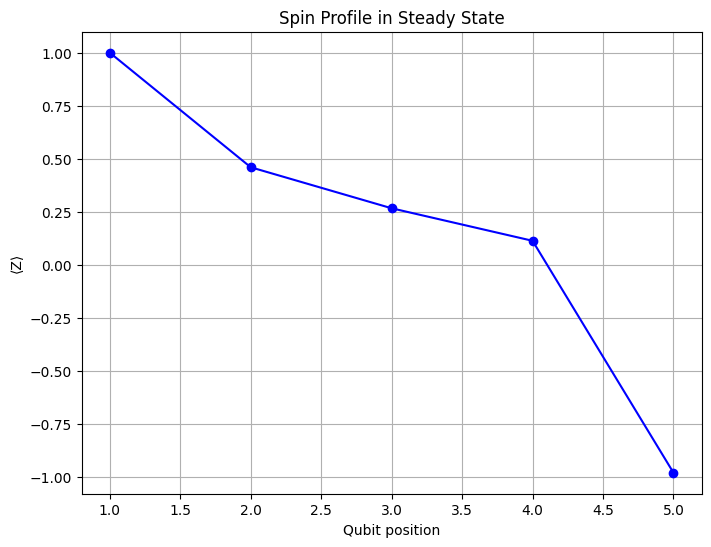

In [157]:
from pytket.circuit import Circuit, OpType, Bit
from pytket.extensions.qiskit import AerStateBackend  # For state vector simulation
import numpy as np
import matplotlib.pyplot as plt

def measure_spin_profile(circuit: Circuit, n_system_qubits: int, n_shots: int = 300):
    """
    Measures Z expectation values for each system qubit.
    """
    # Create a statevector simulator backend
    backend = AerStateBackend()
    z_expectations = []
    
    for i in range(n_system_qubits):
        print(f"i = {i}")
        # Create copy of circuit and add measurement
        measure_circ = circuit.copy()
        # Access system register correctly
        sys_reg = measure_circ.get_q_register("system")
        # Add classical register for measurement
        measure_circ.add_c_register("c", 1)
        # Add measurement
        measure_circ.Measure(sys_reg[i], Bit("c", 0))
        
        # Compile circuit
        compiled_circ = backend.get_compiled_circuit(measure_circ)

        #if(i == 0): render_circuit_jupyter(compiled_circ)
        
        # Run circuit and get results
        handle = backend.process_circuit(compiled_circ, n_shots=n_shots)
        shots = backend.get_result(handle).get_counts()
        
        # Calculate expectation value
        exp_val = 0
        for bitstring, count in shots.items():
            print(bitstring)
            print(count)
            value = 1 if bitstring[0] == 0 else -1
            exp_val += value * count
        exp_val /= n_shots
        
        z_expectations.append(exp_val)
    
    return z_expectations

N = 5  # Number of system qubits
M = 30  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
z_expectations = measure_spin_profile(lindblad_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), z_expectations, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨Z⟩')
plt.title('Spin Profile in Steady State')
plt.grid(True)
plt.show()


### Task 5: Explore other parameter choices

What happens if you choose larger time steps $\Delta t$, i.e. smaller $M$. Is there a minimum value for $M$ to get reasonable results? You can also explore other parameter settings, i.e. larger $\Delta_{ZZ}$ (the $ZZ$ interaction in the Hamiltonian) or larger $\epsilon$ (which controls the interaction between the boundary qubits and the environment). What would you expect for very large or very small $\epsilon$?

i = 0
(1,)
52
(0,)
248
i = 1
(0,)
162
(1,)
138
i = 2
(1,)
174
(0,)
126
i = 3
(0,)
90
(1,)
210
i = 4
(0,)
43
(1,)
257


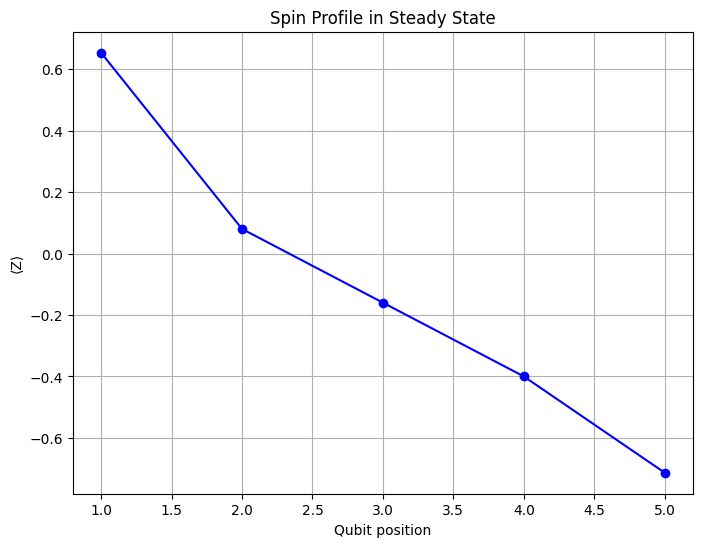

In [129]:
N = 5  # Number of system qubits
M = 30  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.8  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
z_expectations = measure_spin_profile(lindblad_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), z_expectations, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨Z⟩')
plt.title('Spin Profile in Steady State')
plt.grid(True)
plt.show()


i = 0
(0,)
300
i = 1
(1,)
11
(0,)
289
i = 2
(1,)
49
(0,)
251
i = 3
(0,)
75
(1,)
225
i = 4
(0,)
2
(1,)
298


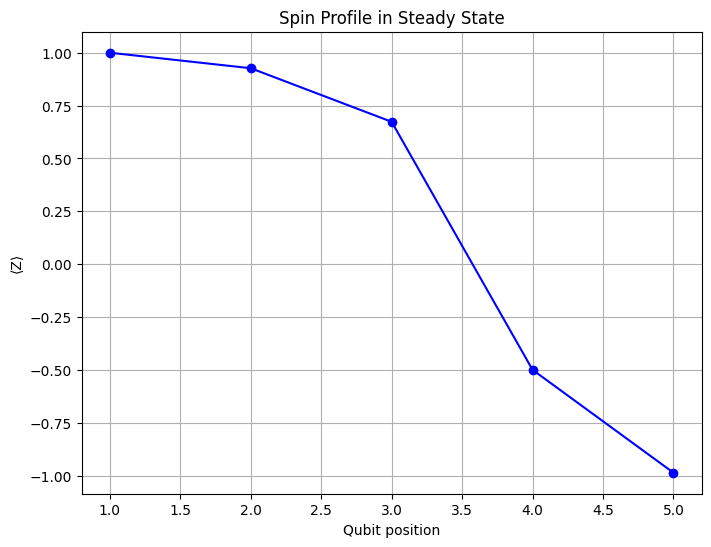

In [158]:
N = 5  # Number of system qubits
M = 30  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 1.5  # ZZ interaction strength

# Generate circuit and measure spin profile
lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
z_expectations = measure_spin_profile(lindblad_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), z_expectations, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨Z⟩')
plt.title('Spin Profile in Steady State')
plt.grid(True)
plt.show()

i = 0
(1,)
31
(0,)
269
i = 1
(0,)
84
(1,)
216
i = 2
(0,)
71
(1,)
229
i = 3
(1,)
250
(0,)
50
i = 4
(0,)
42
(1,)
258


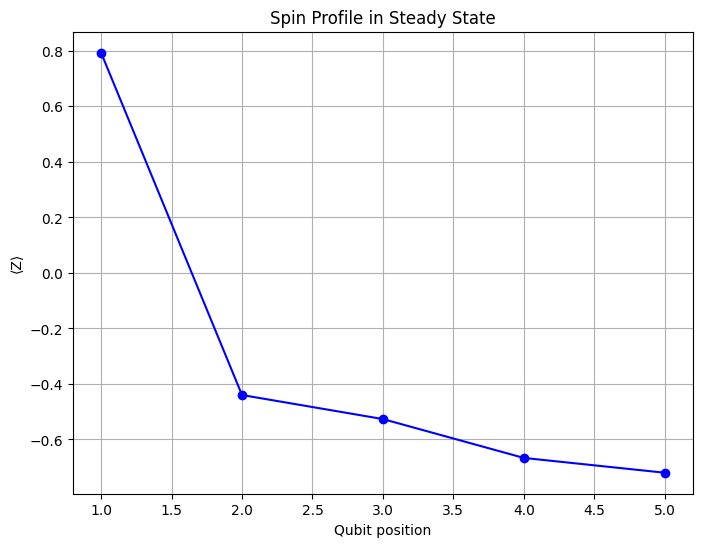

In [159]:
N = 5  # Number of system qubits
M = 10  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
z_expectations = measure_spin_profile(lindblad_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), z_expectations, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨Z⟩')
plt.title('Spin Profile in Steady State')
plt.grid(True)
plt.show()

i = 0
(0,)
300
i = 1
(0,)
280
(1,)
20
i = 2
(1,)
97
(0,)
203
i = 3
(0,)
24
(1,)
276
i = 4
(1,)
300


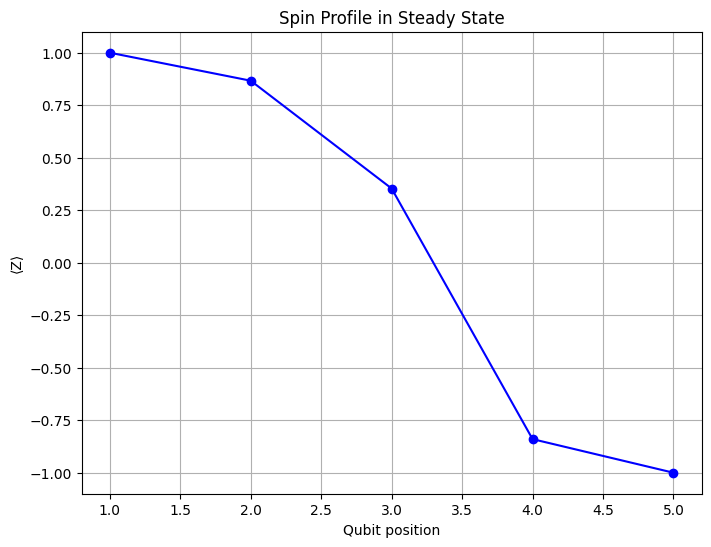

In [160]:
N = 5  # Number of system qubits
M = 20  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
z_expectations = measure_spin_profile(lindblad_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), z_expectations, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨Z⟩')
plt.title('Spin Profile in Steady State')
plt.grid(True)
plt.show()

i = 0
(0,)
300
i = 1
(1,)
135
(0,)
165
i = 2
(0,)
118
(1,)
182
i = 3
(0,)
83
(1,)
217
i = 4
(0,)
1
(1,)
299


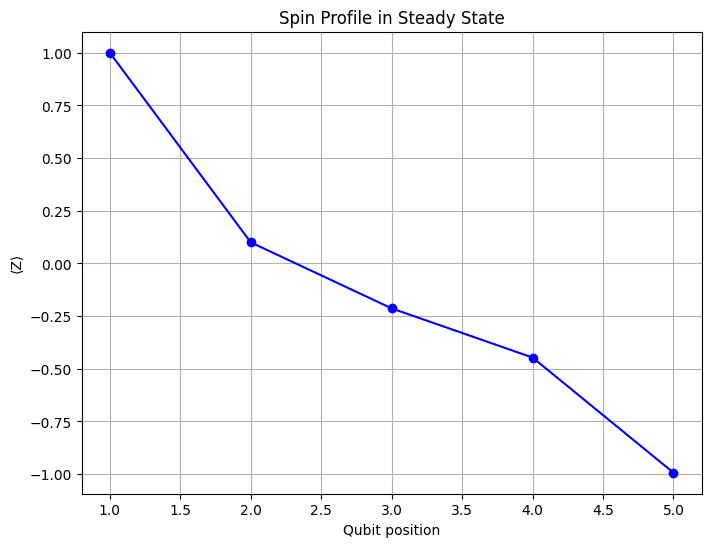

In [161]:
N = 5  # Number of system qubits
M = 15  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
z_expectations = measure_spin_profile(lindblad_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), z_expectations, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨Z⟩')
plt.title('Spin Profile in Steady State')
plt.grid(True)
plt.show()

# Task 5 Analysis

1. Increasing $\epsilon$ by a factor of 4 (from $0.2$ to $0.8$) leads to the graph becoming more linear.

2. Increasing $\Delta_ZZ$ by a factor of 3 (from $0.5$ to $1.5$) leads to the graph being less like a line or sinusoid, and being more like a sigmoid curve with a higher $k$ (steepness).

3. Decreasing $M$ to $20$ still results in a very good simulation of the behavior of the Lindbladian as evidenced by the state profile. Decreasing it to $15$ results in the spin profile starting to differ somewhat significantly, while decreasing it to $10$ results in a poor simulation.

### Task 6: Comparison to Hamiltonian simulation

Next we compare the long time behavior of the output of the Lindbladian and the Hamiltonians time evolution circuits.

- Compute the spin profile for the same setting as above but using only Hamiltonian simulation.
- Compute the spin profile under both the Lindbladian and the Hamiltonian for some values of $T$ in the interval $[98, 102]$.
- Do the same for the $X$ spin profile, i.e. compute the expectation values of $X^{(i)}$ for $i =1,\dots, N$. You can also explore correlators $X^{(i)} X^{(j)}$.
- How do the solutions behave differently? Why is the long-time evolved state under the Lindbladian also called "steady state"?

In [154]:
def get_hamiltonian_circuit_wrapper(
    n_qubits: int,
    M: int,  # Number of time steps
    T: float,  # Total evolution time
    epsilon: float,  # Coupling strength
    Delta_ZZ: float  # ZZ interaction strength
) -> Circuit:
    circ = Circuit()
    #anc_reg = circ.add_q_register("ancilla", 2)  # Two ancilla qubits
    sys_reg = circ.add_q_register("system", n_qubits)

    dt = T / M  # Time step size

    # puts it in superposition
    #circ.H(Qubit("system", 0))
    
    #for i in range(n_qubits - 1): 
    #    circ.CX(Qubit("system", i), Qubit("system", i + 1))
        
    for _ in range(M):
        apply_single_trotter_hamiltonian_operator(circ, dt, n_qubits, Delta_ZZ)
    #render_circuit_jupyter(circ)
    return circ

i = 0
(0,)
154
(1,)
146
i = 1
(0,)
152
(1,)
148
i = 2
(1,)
158
(0,)
142
i = 3
(0,)
158
(1,)
142
i = 4
(0,)
144
(1,)
156


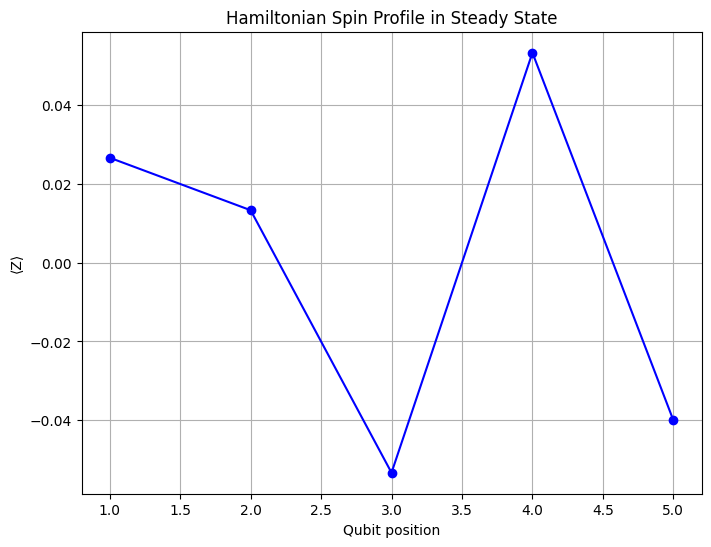

In [155]:
N = 5  # Number of system qubits
M = 30  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
hamiltonian_circuit = get_hamiltonian_circuit_wrapper(N, M, T, epsilon, Delta_ZZ)
z_expectations_ham = measure_spin_profile(hamiltonian_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), z_expectations_ham, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨Z⟩')
plt.title('Hamiltonian Spin Profile in Steady State')
plt.grid(True)
plt.show()

In [170]:
def measure_X_spin_profile(circuit: Circuit, n_system_qubits: int, n_shots: int = 300):
    """
    Measures X expectation values for each system qubit.
    """
    # Create a statevector simulator backend
    backend = AerStateBackend()
    x_expectations = []
    
    for i in range(n_system_qubits):
        print(f"i = {i}")
        # Create copy of circuit and add measurement
        measure_circ = circuit.copy()
        # Access system register correctly
        sys_reg = measure_circ.get_q_register("system")
        # Add classical register for measurement
        measure_circ.add_c_register("c", 1)

        # convert measure to in X
        measure_circ.H(sys_reg[i])
        
        # Add measurement
        measure_circ.Measure(sys_reg[i], Bit("c", 0))
        
        # Compile circuit
        compiled_circ = backend.get_compiled_circuit(measure_circ)

        #if(i == 0): render_circuit_jupyter(compiled_circ)
        
        # Run circuit and get results
        handle = backend.process_circuit(compiled_circ, n_shots=n_shots)
        shots = backend.get_result(handle).get_counts()
        
        # Calculate expectation value
        exp_val = 0
        for bitstring, count in shots.items():
            print(bitstring)
            print(count)
            value = 1 if bitstring[0] == 0 else -1
            exp_val += value * count
        exp_val /= n_shots
        
        x_expectations.append(exp_val)
    
    return x_expectations

i = 0
(0,)
144
(1,)
156
i = 1
(0,)
166
(1,)
134
i = 2
(1,)
136
(0,)
164
i = 3
(1,)
158
(0,)
142
i = 4
(1,)
145
(0,)
155


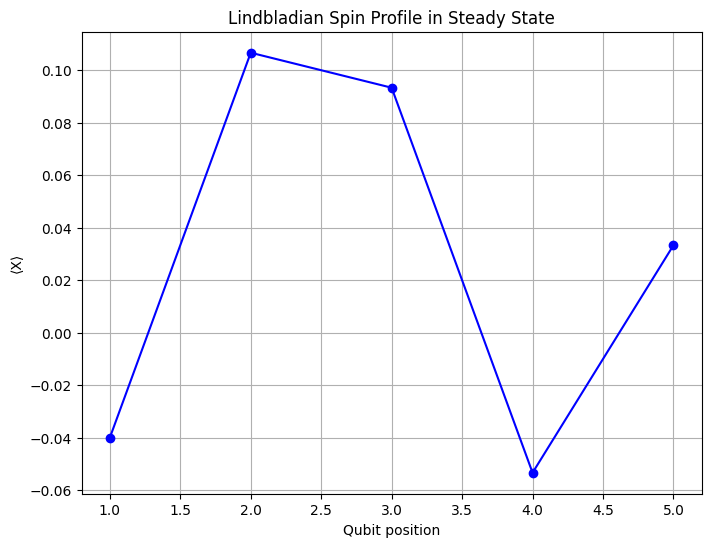

In [172]:
N = 5  # Number of system qubits
M = 30  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
x_expectations = measure_X_spin_profile(lindblad_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), x_expectations, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨X⟩')
plt.title('Lindbladian Spin Profile in Steady State')
plt.grid(True)
plt.show()

i = 0
(0,)
149
(1,)
151
i = 1
(0,)
130
(1,)
170
i = 2
(0,)
145
(1,)
155
i = 3
(0,)
145
(1,)
155
i = 4
(0,)
158
(1,)
142


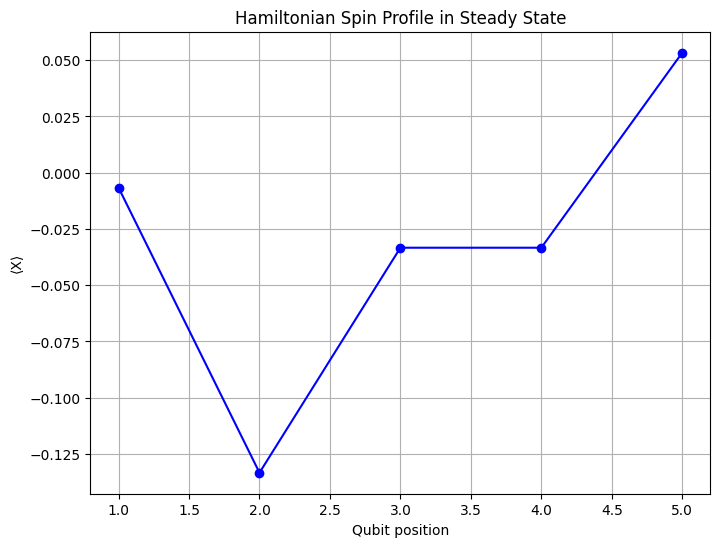

In [171]:
N = 5  # Number of system qubits
M = 30  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
hamiltonian_circuit = get_hamiltonian_circuit_wrapper(N, M, T, epsilon, Delta_ZZ)
x_expectations_ham = measure_X_spin_profile(hamiltonian_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), x_expectations_ham, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨X⟩')
plt.title('Hamiltonian Spin Profile in Steady State')
plt.grid(True)
plt.show()

### Task 7: Influence of noise

How does hardware noise influence the results. Simulate the circui with some noise models, e.g. Quantinuum noise models.

In [175]:
project = qnx.projects.get_or_create(name="iquhack")
qnx.context.set_active_project(project)

In [182]:
from pytket.circuit import Circuit, OpType, Bit
from pytket.extensions.qiskit import AerStateBackend  # For state vector simulation
import numpy as np
import matplotlib.pyplot as plt

import qnexus as qnx
import datetime

def measure_spin_profile_with_noise(circuit: Circuit, n_system_qubits: int, n_shots: int = 300):
    """
    Measures Z expectation values for each system qubit with noise
    """
    z_expectations = []
    
    for i in range(n_system_qubits):
        print(f"i = {i}")
        # Create copy of circuit and add measurement
        measure_circ = circuit.copy()
        # Access system register correctly
        sys_reg = measure_circ.get_q_register("system")
        # Add classical register for measurement
        measure_circ.add_c_register("c", 1)
        # Add measurement
        measure_circ.Measure(sys_reg[i], Bit("c", 0))

        temp_suffix = datetime.datetime.now().strftime("%Y_%m_%d-%H-%M-%S")

        h1_config = qnx.QuantinuumConfig(device_name="H1-Emulator")

        print("awaiting compilation")
        
        ref = qnx.circuits.upload(circuit=measure_circ, name=f"z-expectation-measure-circuit-{temp_suffix}")
        ref_compile_job = qnx.start_compile_job(
            circuits=[ref],
            backend_config=h1_config,
            optimisation_level=2,
            name=f"compilation-job-{temp_suffix}"
        )
        qnx.jobs.wait_for(ref_compile_job)

        print("compiled!")
        
        ref_compiled_circuit = qnx.jobs.results(ref_compile_job)[0].get_output() 

        ref_execute_job = qnx.start_execute_job(
            circuits=[ref_compiled_circuit], 
            n_shots=[n_shots], 
            backend_config=h1_config, 
            name=f"execution-job-{temp_suffix}"
        )

        qnx.jobs.wait_for(ref_execute_job)

        print("executed!")

        ref_result = qnx.jobs.results(ref_execute_job)[0]
        backend_result = ref_result.download_result() 

        shots = backend_result.get_counts()
        
        # Compile circuit
        #compiled_circ = backend.get_compiled_circuit(measure_circ)

        #if(i == 0): render_circuit_jupyter(compiled_circ)
        
        # Run circuit and get results
        #handle = backend.process_circuit(compiled_circ, n_shots=n_shots)
        #shots = backend.get_result(handle).get_counts()
        
        # Calculate expectation value

        print(shots)
        
        exp_val = 0
        for bitstring, count in shots.items():
            print(bitstring)
            print(count)
            value = 1 if bitstring[0] == 0 else -1
            exp_val += value * count
        exp_val /= n_shots
        
        z_expectations.append(exp_val)
    
    return z_expectations


i = 0
awaiting compilation
compiled!
executed!
Counter({(0,): 298, (1,): 2})
(0,)
298
(1,)
2
i = 1
awaiting compilation
compiled!
executed!
Counter({(0,): 210, (1,): 90})
(0,)
210
(1,)
90
i = 2
awaiting compilation
compiled!
executed!
Counter({(0,): 189, (1,): 111})
(0,)
189
(1,)
111
i = 3
awaiting compilation
compiled!
executed!
Counter({(0,): 167, (1,): 133})
(0,)
167
(1,)
133
i = 4
awaiting compilation
compiled!
executed!
Counter({(1,): 296, (0,): 4})
(0,)
4
(1,)
296


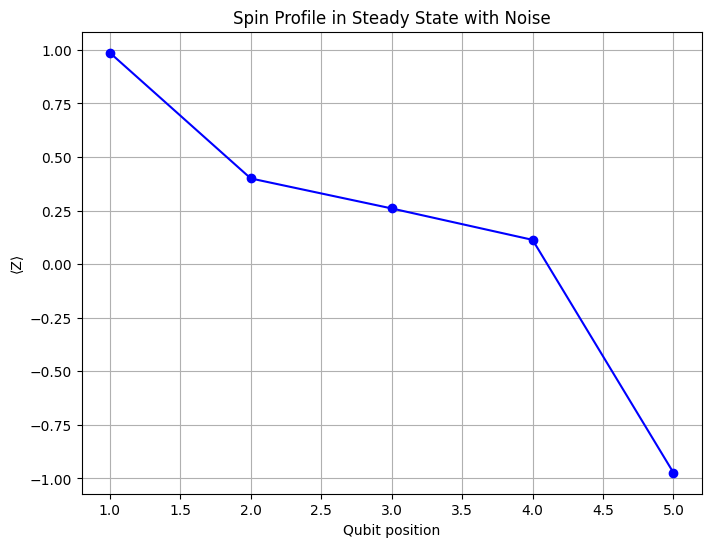

In [183]:
N = 5  # Number of system qubits
M = 30  # Number of time steps
T = 100  # Total evolution time
epsilon = 0.2  # Coupling strength
Delta_ZZ = 0.5  # ZZ interaction strength

# Generate circuit and measure spin profile
lindblad_circuit = get_lindblad_circuit(N, M, T, epsilon, Delta_ZZ)
z_expectations_noisy = measure_spin_profile_with_noise(lindblad_circuit, N)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(range(1, N+1), z_expectations_noisy, 'bo-')
plt.xlabel('Qubit position')
plt.ylabel('⟨Z⟩')
plt.title('Spin Profile in Steady State with Noise')
plt.grid(True)
plt.show()

### Task 8: Study the randomized version of the algorithm

The above protocol can be randomized. That means that in each time step, we select on of the jump operators at random, and only apply the corresponding dilated operator.
This means, that we approximate the time evolution up to time $T = M \Delta t$ by
\begin{equation}
e^{M\Delta t \mathcal{L}} [\rho]
= \left( \prod_{i = 1}^M e^{\Delta t \mathcal{D}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
= \left( \prod_{i = 1}^M e^{\Delta t S \mathcal{D}_{a_i}} \circ \mathcal{U}_{\Delta t} \right) [\rho] 
\,,
\quad \text{with} \quad
\mathcal{U}_{\Delta t} [\rho] = e^{-i\Delta t H} \rho e^{i\Delta t H} \,,
\end{equation}
where in each time step $i$ we randomly select one of the jump operators $L_{a_i}$ and apply the corresponding single-jump dissipator $\mathcal{D}_{a_i}$. Note the number of jump operators $S$ appearing in the exponent $e^{\Delta t S \mathcal{D}_{a_i}}$. For the model considered here we have $S = 2$.

See circuit picture and discussion of the randomized protocol above.

### Task 9: Explore other settings

Explore other initial states or monitor the energy (the expectation value of the Hamiltonian) along the dissipative time evolution. What would you expect? How should this be different from the Hamiltonian simulation scenario of `notebooks/hamiltonian_simulation.ipynb`?

### Task 10: Other dissipative systems

Study the models and use-cases considered in [6,7].

### Task 11: Classical simulation

Develop, apply or improve classical computational methods, e.g. tensor network or quantum jump and Monte Carlo solvers (see e.g. qutip), to simulate open system dynamics.